In [66]:
import django
import sys, os
import datetime
import random
import matplotlib.pyplot as plt

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

import pandas as pd
import numpy as np


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import datetime

from learning_utils import utils

In [67]:
q = Query.objects.get(pk=1457)

In [68]:
columns = [
    'id',
    'UT_id',
    'authors',
    'content',
    'first_author',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

In [69]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

(1984, 13)


,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date
0,799,WOS:000287262500004,"Stubelj, I, Dolenc, P",This paper tackles the question of fiscal sust...,"Stubelj, I",171538,2018-09-19 15:52:45.053905+00:00,0,753,FISCAL SUSTAINABILITY OF EU MEMBER STATES IN T...,public finance; sustainability; budget balance...,['Economics'],2018-09-19 15:52:45
1,1102,WOS:000295803500003,"Johnson, BH, Poulsen, TG, Hansen, JA, Lehmann, M",There is a strong connection between economic ...,"Johnson, BH",635393,2018-09-07 08:10:25.795637+00:00,1,737,Cities as development drivers: from waste prob...,Climate change; mitigation; innovation systems...,"['Engineering, Environmental; Environmental Sc...",2018-09-07 08:10:25
2,2524,WOS:000382709200004,"Bhandari, J, Pan, XB, Zhang, LZ, Bijaya, GCD, ...","For ecological sustainability, legumes play a ...","Bhandari, J",464985,2018-09-24 04:07:31.184604+00:00,1,760,Biomass and species richness of legumes of sem...,Biomass; Inner Mongolia; Legumes; Semiarid gra...,['Agronomy'],2018-09-24 04:07:31
3,1753,WOS:000369388300004,"Kurian, JC, Kurian, JC",Purpose - The purpose of this paper is to expl...,"Kurian, JC",103496,2018-09-21 02:36:32.826474+00:00,0,753,Facebook use by the open access repository users,Social networking sites; Open access; Reposito...,"['Computer Science, Information Systems; Infor...",2018-09-21 02:36:32
4,2214,WOS:000268802200019,"de Almeida, MVR, de Oliveira, TS, Bezerra, AME",Biodiversity is important for the quality of a...,"de Almeida, MVR",506301,2018-09-24 04:10:31.541097+00:00,1,760,Biodiversity in agroecological systems in Chor...,agroecology; intercropping systems; semiarid; ...,['Agronomy'],2018-09-24 04:10:31


In [70]:
uncoded_docs = Doc.objects.filter(query=q,content__iregex='\w').exclude(docownership__relevant__gt=0)
uncoded_docs_nosus = Doc.objects.filter(
    query=q,content__iregex='\w'
).exclude(
    docownership__relevant__gt=0
).exclude(
    wosarticle__so__icontains="sustainab"
)

wos_sus = Doc.objects.filter(
    query=q,
    wosarticle__kwp__icontains="sustainab"
).exclude(
    title__icontains="sustainab"
).exclude(
    content__icontains="sustainab"
).exclude(
    wosarticle__de="sustainab"
).values_list('pk',flat=True)

t753 = Doc.objects.filter(tag__id=753).values_list('pk',flat=True)

uncoded_docs_nosus = uncoded_docs_nosus.exclude(id__in=list(wos_sus)+list(t753))



In [71]:
s_ids = random.sample(list(
    uncoded_docs_nosus.values_list('pk',flat=True)
),4000)

new_docs = Doc.objects.filter(id__in=s_ids)

unseen = list(new_docs.values(*columns))
new_df = pd.DataFrame.from_dict(unseen)

In [72]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=15, max_df=0.6, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X = vec.fit_transform(list(df['content']) + list(new_df['content']))

In [73]:
ab_X

len(df.index)

X_train = ab_X[list(range(len(df.index)))]
y_train = list(df['relevant'])

X_pred = ab_X[len(df.index):]

print(ab_X.shape)
print(X_train.shape)
print(X_pred.shape)

(5984, 5381)
(1984, 5381)
(4000, 5381)


In [74]:
clf = MultinomialNB(alpha=0.1)     
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_pred)

new_df['prediction'] = y_pred[:,1]

In [75]:
new_df.sort_values('prediction').head()

,UT_id,authors,content,first_author,id,title,wosarticle__de,wosarticle__wc,prediction
3523,WOS:000294812400001,"Souza, NM, Sebaldt, RJ, Mackay, JA, Prorok, JC...",Background: Computerized clinical decision sup...,"Souza, NM",189334,Computerized clinical decision support systems...,None,[Health Care Sciences & Services; Health Polic...,0.000406
651,WOS:000284763500004,"Lau, G, Wieland, B, Seifert, D, Siskind, D",Objective: This study evaluates the partnershi...,"Lau, G",477624,A partnership evaluation: public mental health...,dental care; dental health services; mental di...,[Psychiatry],0.000798
2342,WOS:000208325000004,"Barcelo, A, Cafiero, E, de Boer, M, Mesa, AE, ...",The prevalence of diabetes in Mexico among tho...,"Barcelo, A",320049,Using collaborative learning to improve diabet...,Diabetes care; Quality improvement,[Endocrinology & Metabolism; Primary Health Care],0.000827
1572,WOS:000275983200017,"Foody, JM, Villablanca, AC, Giardina, EGV, Gil...","Aims: Improving, Enhancing and Evaluating Outc...","Foody, JM",745692,The Office on Women's Health Initiative to Imp...,None,"[Public, Environmental & Occupational Health; ...",0.000873
378,WOS:000372370800012,"White, DAE, Anderson, ES, Pfeil, SK, Graffman,...",Introduction: Nontargeted human immunodeficien...,"White, DAE",174898,DIFFERENCES BETWEEN EMERGENCY NURSE PERCEPTION...,Hepatitis C virus screening; HIV screening; Em...,[Emergency Medicine; Nursing],0.001317


In [76]:
for i, row in new_df.sort_values('prediction',ascending=False).head(5).iterrows():
    print(row['title'])
    print("predicted: {:.2}".format(row['prediction']))
    print(row['content'])

Land demand for ethanol production
predicted: 1.0
Several key indicators of the sustainability of biofuels are related to the land used to produce the feedstock. Most of the agronomic costs and energy use (fertilizers, herbicides, soil preparation, and harvesting) are more related to the cropped area than to the feedstock quantity produced; this is also the case of soil greenhouse gas (GHG) emissions (CO2 and N2O) and land use change (LUC) impacts, both direct (dLUC) and indirect (iLUC), socio-economic impacts (land tenure, land prices and traditional crop displacement), impacts on biodiversity and on the environment (soil, water and air). Today, biofuels use only a little more than 2% of the world arable land but if their use to displace fossil fuels increases, as indicated by some low carbon scenarios, the land demand for the production of feedstocks could become a constraint to the expansion. It is quite apparent that the biofuel yields, present and future, should be one of the main

In [62]:
for i, row in new_df.sort_values('prediction').head(5).iterrows():
    print(row['title'])
    print("predicted: {:.2}".format(row['prediction']))
    print(row['content'])

Implementation of a routine HIV testing policy in an acute medical setting in a UK general hospital: a cross-sectional study
predicted: 0.00016
Objectives To report the implementation and outcomes of a routine opt-out HIV testing policy in an acute medical unit (AMU) of a district general hospital in an area of high diagnosed HIV prevalence. Methods Since July 2011, all patients aged 16-79 years attending AMU were offered an HIV test as a hospital policy. Consenting and arranging the test was carried out by general medical staff, with training and motivational support by local HIV specialists. A retrospective cross-sectional review was conducted: testing rate and outcomes of those testing HIV seropositive were determined by review of hospital data systems and case notes. Results Over a 21-month period, there were 12 682 admissions; 4122 (32.5%) had HIV tests. 20 patients (0.48%) were diagnosed with HIV; 17 (85%) of them were new diagnoses. Compared with those patients targeted as a res

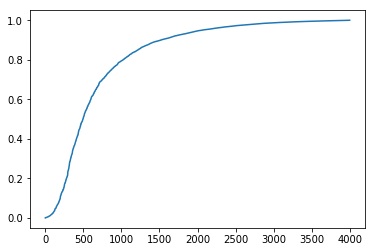

In [77]:
pdf = new_df.sort_values('prediction').reset_index(drop=True)
plt.plot(pdf.index,pdf['prediction'])

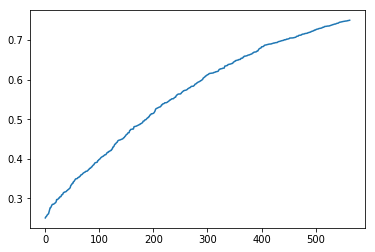

In [78]:
uncertain = new_df[
    (new_df['prediction'] > 0.25) & (new_df['prediction'] < 0.75)
].sort_values('prediction').reset_index(drop=True)

plt.plot(uncertain.index,uncertain['prediction'])

In [79]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
tag = Tag(
    title="predicted irrelevant sample {}".format(now),
    query=q
)
tag.save()
uc = q.users.count()
for i, row in uncertain.iterrows():#.sort_values('prediction').head(500).iterrows():
    d = Doc.objects.get(UT__UT=row['UT_id'])
    u = q.users.all()[i % uc]
    do = DocOwnership(
        doc=d,
        user=u,
        query=q,
        tag=tag
    )
    do.save()

In [29]:
new_df.to_csv(f'predicted_docs{now}.csv')